In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
%matplotlib inline

import nltk
import tqdm
from collections import Counter

import torch
from torch import nn
import torch.nn.functional as F

from Bio import SeqIO

In [2]:
files = os.listdir('data/proteomes_without_trembl/')

files[:5]

tmp = []

for file_name in files:
    tmp.append('data/proteomes_without_trembl/'+file_name)
    
files = tmp

files[:5]

['data/proteomes_without_trembl/YERS_pestis.fasta',
 'data/proteomes_without_trembl/Ecoli.fasta',
 'data/proteomes_without_trembl/KLEB_pneumoniae.fasta',
 'data/proteomes_without_trembl/MYPL_synoviae.fasta',
 'data/proteomes_without_trembl/adenovirus.fasta']

In [55]:
# making dataframe

data = pd.DataFrame(columns=['organism', 'protein', 'target'])

names = []


for file_name in files:
    
    tmp_dict = {'organism':[], 'protein':[], 'target':[]}
    
    file_records = SeqIO.parse(file_name, 'fasta')
    
    for record in file_records:
        
        protein = record.seq
        
        org_name = file_name[len(file_name) - file_name[::-1].find('/'):].replace('.fasta', '').upper()
            
        names.append(org_name)
        
        tmp_dict['protein'].append(protein)
        tmp_dict['organism'].append(org_name)
        
        if org_name != 'HUMAN_PROTEOME':
            tmp_dict['target'].append(0)
        else:
            tmp_dict['target'].append(1)
        
    tmp_df = pd.DataFrame(tmp_dict)
    
    #print(tmp_df)
    
    data = pd.concat((data, tmp_df), ignore_index=True, axis=0)


data.protein = data.protein.apply(str)    

data.head()

,organism,protein,target
0,YERS_PESTIS,MTLTSAHPKSKLMKRFAALGPYLREGQCQNDHFFFDCLAVCINVKL...,0
1,YERS_PESTIS,MKGYLWGGASVVLVTVAQLVLKWGMMNIPLLSLADINVQFLTMYFV...,0
2,YERS_PESTIS,MVTTLDNALLNDILQQVRPLIGQGKVADYIPALAEVPANKLGIAVC...,0
3,YERS_PESTIS,MQKYIVEARSLLALAIPVVIAQLSQTAMGVVDTIMAGSVSATDMAA...,0
4,YERS_PESTIS,MTLKELVVGFGTQVRSLWMIGLHAFHKRETLMYPEEPVYLPPRYRG...,0


In [7]:
one2all ={'A': ('A', 'ALA', 'alanine'),
              'R': ('R', 'ARG', 'arginine'),
              'N': ('N', 'ASN', 'asparagine'),
              'D': ('D', 'ASP', 'aspartic acid'),
              'C': ('C', 'CYS', 'cysteine'),
              'Q': ('Q', 'GLN', 'glutamine'),
              'E': ('E', 'GLU', 'glutamic acid'),
              'G': ('G', 'GLY', 'glycine'),
              'H': ('H', 'HIS', 'histidine'),
              'I': ('I', 'ILE', 'isoleucine'),
              'L': ('L', 'LEU', 'leucine'),
              'K': ('K', 'LYS', 'lysine'),
              'M': ('M', 'MET', 'methionine'),
              'F': ('F', 'PHE', 'phenylalanine'),
              'P': ('P', 'PRO', 'proline'),
              'S': ('S', 'SER', 'serine'),
              'T': ('T', 'THR', 'threonine'),
              'W': ('W', 'TRP', 'tryptophan'),
              'Y': ('Y', 'TYR', 'tyrosine'),
              'V': ('V', 'VAL', 'valine'),
              'X': ('X', 'GLX', 'glutaminx'),
              'Z': ('Z', 'GLI', 'glycine'),
              'J': ('J', 'NLE', 'norleucine'),
          'U': ('U', 'CYC', 'cysteinc')}

In [10]:
alphabet = list(one2all.keys())

In [175]:
def protein_slicing(protein):
    pieces = []
    
    i = 10
    j = 0
    
    while i < len(protein):
        pieces.append(protein[j:i])
        i += 2
        j += 2
        
    return pieces

def tokenization(piece, alphabet):
    
        
    i = 0

    vector = [0 for i in range(24)]

    for aa in alphabet:
        vector[i] = piece.count(aa)

        i += 1
        
    return vector

def token_proteins(proteins, target):
    
    matrix = []
    target_out = []
    
    n = 0
    
    for ind, protein in enumerate(proteins):
        
        #print(protein)
    
        pieces = protein_slicing(protein)
        
        n += len(pieces)
        
        for piece in pieces:
            
            matrix.append(tokenization(piece, alphabet))
            target_out.append(target[ind])
            
    return np.array(matrix).reshape(n,24), np.array(target_out)

In [163]:
proteins = list(data.protein[0:2])
target = list(data.target[0:2])

list(enumerate(proteins))

[(0,
  'MTLTSAHPKSKLMKRFAALGPYLREGQCQNDHFFFDCLAVCINVKLAPEKREFWGWWIELEPSAGRFTYVYQLGLFNKEGNWNAEKISDPEVQDKLESTLRSFHLRLEEMLASIDMKLEPAADFNDQPVKLSA'),
 (1,
  'MKGYLWGGASVVLVTVAQLVLKWGMMNIPLLSLADINVQFLTMYFVQLASVMCGLMGYALSMLCWFFALRYLPLNRAYPLLSLSYALVYLGAVLLPWFNEPATLLKTLGAGFILLGIWLINIKPIKAS')]

In [157]:
all_indices = [i for i in data.index]

human_indices = list(data.loc[data.organism == 'HUMAN_PROTEOME'].index)

In [176]:
def iterate_minibatches(data, batch_size=100, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            proteins = list(data.protein.iloc[indices[start : start + batch_size]])
            target = list(data.target.iloc[indices[start : start + batch_size]])
            #print(proteins, target)
            batch, target_out = token_proteins(proteins, target)
            yield batch, target_out
        
        if not cycle: break

In [177]:
iterator = iterate_minibatches(data)

batch, target_out = next(iterator)

In [186]:
batch.shape

torch.Size([18839, 24])

In [130]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  91750
Validation size =  10195


In [180]:
n_tokens=24
simple_model = nn.Sequential()

simple_model.add_module('linear_1', nn.Linear(in_features=n_tokens, out_features=200))
simple_model.add_module('linear_2', nn.Linear(in_features=200, out_features=1))

In [184]:
simple_model(torch.tensor(batch, dtype=torch.float)).size()

/home/belsawan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


torch.Size([18839, 1])

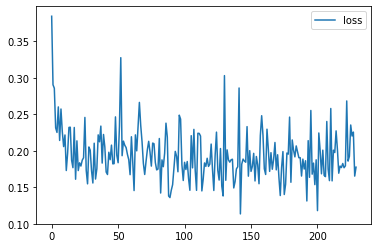

KeyboardInterrupt: 

In [189]:
from IPython.display import clear_output
from random import sample

epochs = 1

model = simple_model
opt = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

history = []
for epoch_num in range(epochs):
    for idx, (batch, target_out) in enumerate(iterate_minibatches(data_train)):
        # Preprocessing the batch data and target
        target_out = torch.tensor(target)
        
        
        batch = torch.tensor(batch, dtype=torch.float)
        
        predictions = model(batch)
        predictions = predictions.view(predictions.size(0))

        loss = loss_func(predictions, target_out)

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())
        if (idx+1)%10==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()